In [34]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import re
import string
import os
import matplotlib.pyplot as plt
import rapidfuzz

In [2]:
epa_df = pd.read_xml("/Users/josheverts/Downloads/vehicles.xml")

# Load in data

In [3]:
## load in epa vehicle data for all years 1985 onwards. Join adjusted weight data to this
epa_df = pd.read_xml("/Users/josheverts/Downloads/vehicles.xml")

## load in data from 2017-2023 stored as excel files
path = "/Users/josheverts/Documents/Epa_AdjWeights/Excel"
os.chdir(path)
## data to join with adjusted weights
weight_dfs = []
for file in os.listdir():
    weight_dfs.append(pd.read_excel(file))

## load in data from 2000-2016, stored as .csv files
path = "/Users/josheverts/Documents/Epa_AdjWeights/csv"
os.chdir(path)
yrs = [] ## record year for data cleaning functions
csv_dfs = []
for file in os.listdir():
    df = pd.DataFrame()
    # Check whether file is in text format or not
    if file.endswith(".csv"):
        yrs.append(int(file[:2]))
        csv_dfs.append(pd.read_csv(file))

In [9]:
## save data into datframes for later use
combined_df1723 = concat_weight_data(weight_dfs, np.arange(17,24)) 
combined_csv0016 = concat_weight_data(csv_dfs, yrs)

# Data cleaning and joining functions
The data differs from year to year and the two datasets don't share a unique vehicle ID. Therefore we have to 
approximate a unique id with the vehicle model column. While this doesn't give a perfect join, it gives reasonable adjusted weight values to work with later. Before 2010 we join on both the make and the model, before 2009 we only join on the model because the models are recorded very differently between the datasets.

In [416]:
def clean_index_adj_weights(adj_weight_df, yr):
    if yr >= 10: ## 2010 or later
        adj_weight_df_grouped = adj_weight_df.groupby(['Represented Test Veh Make',
                                                       'Represented Test Veh Model', 
                                                       'Veh Mfr Code'], group_keys = False).mean(numeric_only = True)
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.rename(columns = {'index':'VehicleID'})
        rename_dict = {'Model Year': 'Year', 'Represented Test Veh Make':'Make', 'Veh Mfr Code': 'MFRCode',
                   'Represented Test Veh Model':'Model', 'Equivalent Test Weight (lbs.)':'AdjWeight'}
        epa_adj_weights = adj_weight_df_grouped.rename(rename_dict, axis=1)  
        epa_adj_weights = epa_adj_weights[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 'AdjWeight']]
        epa_adj_weights.astype({'Year': 'int32'})
    else:        
        adj_weight_df_grouped = adj_weight_df.groupby(['VI_MFR_NM',
                                                       'CL_NM', 
                                                       'VI_MFR_CD'], group_keys = False).mean(numeric_only = True)
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.rename(columns = {'index':'VehicleID'})
        rename_dict = {'MDLYR_DT': 'Year', 'VI_MFR_NM':'Make', 'VI_MFR_CD': 'MFRCode',
                   'CL_NM':'Model', 'VC_DSN_ETW_MSR':'AdjWeight'}
        epa_adj_weights = adj_weight_df_grouped.rename(rename_dict, axis=1)  
        epa_adj_weights = epa_adj_weights[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 'AdjWeight']]
        epa_adj_weights.astype({'Year': 'int32'})
        
    return epa_adj_weights

def clean_index_vehicle_data(vehicle_df):
    
    ## rename columns of each df
    rename_dict = {'id': 'VehicleID', 'make': 'Make', 'model':'Model', 'mfrCode':'MFRCode', 'range': 'Range',
              'rangeHwy': 'RangeHwy', 'year':'Year'}
    vehicle_df = vehicle_df.rename(rename_dict, axis=1)
    
    ## vehicle atvType are:
    vehicle_df['atvType'].unique()
    ## if None or Diesel, assign ICE
    ## if Hybrid assign HEV
    ## if Plug-in Hybrid assigh PHEV
    ## if FFV assign FCV
    def convert_vals(vals):
        out = []
        for val in vals:
            if pd.isna(val) == True or val == 'Diesel':
                out.append('ICE')
            elif val == 'Hybrid':
                out.append('HEV')
            elif val == 'Plug-in Hybrid':
                out.append('PHEV')
            elif val == 'EV':
                out.append(val)
            elif val == 'FFV':
                out.append('ICE')
            else:
                out.append('NA')
        return out
    new_codes = convert_vals(vehicle_df['atvType'])
    vehicle_df['atvType'] = new_codes
    vehicle_df = vehicle_df[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 
                             'Range', 'RangeHwy', 'rangeHwyA','atvType', 
                             'UHighway', 'UCity', 'city08', 'highway08', 'combE', 
                             'combinedUF', 'comb08', 'trany', 'cylinders', 'displ', 'baseModel']]
    return vehicle_df

def concat_weight_data(weight_dfs, yrs):
    combined = pd.DataFrame()
    for df, yr in zip(weight_dfs, yrs):
        cleaned = clean_index_adj_weights(df, yr)
        combined = pd.concat([combined, cleaned])
    combined['Year'] = combined['Year'].astype('int')
    combined['VehicleID'] = np.arange(0, len(combined)) ## assign new unique ids
    combined = combined.reset_index().drop(['index'], axis = 1)
    return combined
        
    
# def vehicle_data_join(vehicle_df, combined_weights):
#     vehicle_df = vehicle_df.copy(); combined_weights = combined_weights.copy()
#     tempdf = vehicle_df[['VehicleID','Year','Make', 'Model']]
#     tempdf2 = vehicle_df[['VehicleID', 'Make', 'Model', 'trany', 'displ', 'cylinders', 'atvType']]
#     vehicle_df['Make'] = vehicle_df['Make'].str.lower()
#     vehicle_df['baseModel'] = vehicle_df['baseModel'].str.lower()
#     vehicle_df['Model'] = vehicle_df['Model'].str.lower()
#     combined_weights['Make'] = combined_weights['Make'].str.lower()
#     combined_weights['Model'] = combined_weights['Model'].str.lower()
#     combined_weights['baseModel'] = [i.split(' ')[0] for i in combined_weights['Model']]
#     ## have to treat pre-2009 years differently, merge on Year, baseModel, not Make
#     data_before_09 = combined_weights[combined_weights['Year'] < 2010]
#     data_after_09 = combined_weights[combined_weights['Year'] >= 2010]
#     adj_join_before_09 = pd.merge(vehicle_df, combined_weights, how='inner', 
#                         left_on=['Year','baseModel'], right_on = ['Year','baseModel'])
#     adj_join_after_09 = pd.merge(vehicle_df, combined_weights, how='inner', 
#                         left_on=['Year', 'Make','baseModel'], right_on = ['Year', 'Make','baseModel'])
#     ## combine initial joins
#     adj_join = pd.concat([adj_join_before_09, adj_join_after_09])
#     adj_join_g = adj_join.groupby(['VehicleID_x']).agg({'UHighway': np.mean, 'UCity': np.mean, 'city08': np.mean, 
#                                                     'Range': np.mean, 'RangeHwy': np.mean, 'rangeHwyA': np.mean,
#                                                     'highway08':  np.mean, 'combE': np.mean, 'combinedUF': np.mean, 
#                                                     'comb08': np.mean, 'AdjWeight': np.mean})  
#     adj_join_g_j = pd.merge(adj_join_g, tempdf2, how = 'inner', left_on='VehicleID_x', right_on='VehicleID')
#     adj_join_final_cap = pd.merge(adj_join_g_j, tempdf, how = 'inner', left_on='VehicleID', right_on='VehicleID')
#     adj_join_final_cap_drop = adj_join_final_cap.drop(['Make_x', 'Model_x'], axis = 1)
#     adj_join_final_cap_drop = adj_join_final_cap_drop.rename({'Make_y': 'Make', 'Model_y': 'Model'}, axis = 1)
#     adj_join_final_cap_drop = adj_join_final_cap_drop[~adj_join_final_cap_drop.duplicated(['Year', 'Make', 'Model', 'trany', 'displ', 'cylinders'])]
#     cols = adj_join_final_cap_drop.columns.to_list()
#     cols = cols[::-1]
#     adj_join_final_cap_drop = adj_join_final_cap_drop[cols]
#     adj_join_final_cap_drop = adj_join_final_cap_drop.reset_index().drop(['index'], axis = 1)
    
#     return adj_join_final_cap_drop


In [11]:
# ### First join the 2000-2016 data, then join the 2017-2023 data
# epa_df_cleaned = clean_index_vehicle_data(epa_df)
# joined_data_00_16 = vehicle_data_join(epa_df_cleaned, combined_csv0016)
# joined_data_17_23 = vehicle_data_join(epa_df_cleaned, combined_df1723)
# ## combine joined dataframes to create years 2000-2023
# joined_data_00_23 = pd.concat([joined_data_00_16, joined_data_17_23])
# joined_data_00_23['VehicleID'] = np.arange(0, len(joined_data_00_23)) ## assign new unique ids
# joined_data_00_23 = joined_data_00_23.reset_index().drop(['index'], axis = 1)

In [417]:
# FCV_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/FCV_data.csv")
# ## concatenate to other vehicle_data
# joined_data_00_23 = pd.concat([joined_data_00_23, FCV_data])

In [418]:
# joined_data_00_23[((joined_data_00_23['Year'] == 2016) & (joined_data_00_23['Make'] == 'Kia'))]

In [419]:
# joined_data_00_23 = joined_data_00_23.reset_index().drop(['index'], axis = 1)
# joined_data_00_23['VehicleID'] = np.arange(0, len(joined_data_00_23)) 

In [420]:
## drop CNG/Bi-fuel vehicles from dataset (labeled as NA)
# joined_data_00_23 = joined_data_00_23.drop(joined_data_00_23[joined_data_00_23['atvType'] == 'NA'].index)

In [421]:
# plt.hist(joined_data_00_23['AdjWeight'], bins = 20)
# plt.title("Adjusted Weight Distribution for Vehicles 2000-2023")

In [422]:
# plt.plot(joined_data_00_23.groupby('Year').count()['Model'])
# plt.title("Number of vehicle models per year in joined data")

# Fuzzy Join functions

In [385]:
def vehicle_data_join(vehicle_df, combined_weights):
    vehicle_df = vehicle_df.copy(); combined_weights = combined_weights.copy()
    tempdf = vehicle_df[['VehicleID','Year','Make', 'Model']]
    tempdf2 = vehicle_df[['VehicleID', 'Make', 'Model', 'trany', 'displ', 'cylinders', 'atvType']]
    vehicle_df['Make'] = vehicle_df['Make'].str.lower()
    vehicle_df['baseModel'] = vehicle_df['baseModel'].str.lower()
    vehicle_df['Model'] = vehicle_df['Model'].str.lower()
    combined_weights['Make'] = combined_weights['Make'].str.lower()
    combined_weights['Model'] = combined_weights['Model'].str.lower()
    combined_weights['baseModel'] = [i.split(' ')[0] for i in combined_weights['Model']]
    ## have to treat pre-2009 years differently, merge on Year, baseModel, not Make
    
    data_before_09 = combined_weights[combined_weights['Year'] < 2010]
    data_after_09 = combined_weights[combined_weights['Year'] >= 2010]
    adj_join_before_09 = pd.merge(vehicle_df, data_before_09, how='inner', 
                        left_on=['Year','baseModel'], right_on = ['Year','baseModel'])
    adj_join_after_09 = pd.merge(vehicle_df, data_after_0, how='inner', 
                        left_on=['Year', 'Make','baseModel'], right_on = ['Year', 'Make','baseModel'])
    ## combine initial joins
    adj_join = pd.concat([adj_join_before_09, adj_join_after_09])
    adj_join_g = adj_join.groupby(['VehicleID_x']).agg({'UHighway': np.mean, 'UCity': np.mean, 'city08': np.mean, 
                                                    'Range': np.mean, 'RangeHwy': np.mean, 'rangeHwyA': np.mean,
                                                    'highway08':  np.mean, 'combE': np.mean, 'combinedUF': np.mean, 
                                                    'comb08': np.mean, 'AdjWeight': np.mean})  
    adj_join_g_j = pd.merge(adj_join_g, tempdf2, how = 'inner', left_on='VehicleID_x', right_on='VehicleID')
    adj_join_final_cap = pd.merge(adj_join_g_j, tempdf, how = 'inner', left_on='VehicleID', right_on='VehicleID')
    adj_join_final_cap_drop = adj_join_final_cap.drop(['Make_x', 'Model_x'], axis = 1)
    adj_join_final_cap_drop = adj_join_final_cap_drop.rename({'Make_y': 'Make', 'Model_y': 'Model'}, axis = 1)
    adj_join_final_cap_drop = adj_join_final_cap_drop[~adj_join_final_cap_drop.duplicated(['Year', 'Make', 'Model', 'trany', 'displ', 'cylinders'])]
    cols = adj_join_final_cap_drop.columns.to_list()
    cols = cols[::-1]
    adj_join_final_cap_drop = adj_join_final_cap_drop[cols]
    adj_join_final_cap_drop = adj_join_final_cap_drop.reset_index().drop(['index'], axis = 1)
    
    return adj_join_final_cap_drop

def clean_match_for_lev(strings):
    cleaned_strings = []
    strings = list(strings)
    for string in strings:
        ## Keep only first token if its an f150:
        tokens =  string.split(' ')
        hybrid_inside = re.search("(?i)hybrid", string)
        plugin_inside = re.search("(?i)plug-in hybrid", string)
        spyder_inside = re.search("(?i)sp[iy]der", string)
        cabriolet_inside = re.search("(?i)cabriolet", string)
        audi_inside = re.search("(?i)a(\d)", tokens[0])
        if tokens[0] == 'f150':
            cleaned_strings.append(' '.join(tokens[:1]))
        if tokens[0] == 'gti':
            cleaned_strings.append('golf gti')
        elif audi_inside:
            cleaned_strings.append(tokens[0])
        elif plugin_inside:
            new_string = string.replace(string[plugin_inside.start():plugin_inside.end()], '')
            cleaned_strings.append(new_string)
        elif hybrid_inside:
            new_string = string.replace(string[hybrid_inside.start():hybrid_inside.end()], '')
            cleaned_strings.append(new_string)
        elif spyder_inside:
            new_string = string.replace(string[spyder_inside.start():spyder_inside.end()], '')
            cleaned_strings.append(new_string)
        elif spyder_inside:
            new_string = string.replace(string[cabriolet_inside.start():cabriolet_inside.end()], '')
            cleaned_strings.append(new_string)
        else:
            cleaned_strings.append(string)
    if len(cleaned_strings) == 1: ## if its only one string, don't return as a list
        return cleaned_strings[0]
    return cleaned_strings
            
            
def get_top_match(str1, match_options, thresh_jaro = 0.8, thresh_lev = 0.65, n=1):
    '''assumes match_options already filtered for make and year'''
#     print(len(match_options))
    if len(match_options) == 0: ## if empty matches
        return -1
    matches = []
    match = rapidfuzz.process.extract(str1, match_options, 
                                      scorer = rapidfuzz.distance.JaroWinkler.normalized_similarity, limit=n, scorer_kwargs={'prefix_weight': 0.125})
#     print(str1, match)
    if float(match[0][1]) >= thresh_jaro: ## if similarity greater than threshold
#         print('here')
#         print(match[0][2])
        return int(match[0][2]) ## return match index
    else:
#         print(int(match[0][1]))
        str1 = clean_match_for_lev([str1])
        match_options = clean_match_for_lev(match_options)
        match = rapidfuzz.process.extract(str1, match_options, 
                                          scorer = rapidfuzz.distance.Levenshtein.normalized_similarity, limit=n, scorer_kwargs={'weights': (1,5,10)})
#         print(str1, match)
        if float(match[0][1]) > thresh_lev:
#             print("here2")
            return int(match[0][2])
    return -1

def fuzzy_join(vehicle_df, combined_weights):
    ## for any entry in vehicle_df, select subset of combined_weights that matches year and make
    vehicle_df = vehicle_df.copy(); combined_weights = combined_weights.copy()
    vehicle_df['Make'] = vehicle_df['Make'].str.lower()
    vehicle_df['baseModel'] = vehicle_df['baseModel'].str.lower()
    vehicle_df['Model'] = vehicle_df['Model'].str.lower()
    combined_weights['Make'] = combined_weights['Make'].str.lower()
    combined_weights['Model'] = combined_weights['Model'].str.lower()
    join_indices = []
    for i in range(len(vehicle_df)):
#         print("progress: %.2f" %((i+1)/len(vehicle_df)), end='\r', flush=True)
        year = vehicle_df.iloc[i]['Year']
        make = vehicle_df.iloc[i]['Make']
        code = vehicle_df.iloc[i]['MFRCode']
        model = vehicle_df.iloc[i]['Model']
        combined_subset = combined_weights[combined_weights['Year'] == year].reset_index()
#         print(len(combined_subset))
        if code == 'TSL':
            reformatted_models = []
            for i in range(len(combined_subset)):
                adj_make = combined_subset.iloc[i]['Make']
                adj_model = combined_subset.iloc[i]['Model']
                if re.search("(?i)tesla", adj_make): ## model name in tesla make (epa input error)
                    adj_model = adj_make[6:] + " " + adj_model
                    reformatted_models.append(adj_model)
                else:
                    reformatted_models.append(adj_model)
            combined_subset['Model'] = reformatted_models

        elif make == 'mazda':
            if re.search("\d", model[0:2]) or model == 'speed 3': 
                model = 'mazda' + model
        elif make == 'nissan':
            reformatted_models_nissan = []
            for i in range(len(combined_subset)):
                adj_model = combined_subset.iloc[i]['Model']
                nissan_inside = re.search("(?i)nissan", adj_model)
                if nissan_inside:
                    adj_model = adj_model.replace(adj_model[nissan_inside.start():nissan_inside.end()], '')
#                     print(adj_model)
                    reformatted_models_nissan.append(adj_model)
                else:
                    reformatted_models_nissan.append(adj_model)
            combined_subset = combined_subset.assign(Model=reformatted_models_nissan)
                    
        else:
            model = model
#         print("listlen:", len(combined_subset['Model']))
        match_index = get_top_match(str(model), list(combined_subset['Model']))
        if match_index == -1:
            join_indices.append(-1)
        else:
#             print(match_index)
            try:
                global_index = combined_subset.iloc[(match_index)]['index']
            except:
                print("list longer than df")
                print(year, make, model)
                global_index == -1
            join_indices.append(global_index)
    ## join based on index
    vehicle_df['match_index'] = join_indices
    combined_weights['index'] = combined_weights.index
    joined_df = pd.merge(vehicle_df, combined_weights, how = 'inner', left_on = 'match_index', right_on = 'index', suffixes=('', '_y'))
    return joined_df

def vehicle_data_join_fuzzy(vehicle_df, combined_weights):
    vehicle_df = vehicle_df.copy(); combined_weights = combined_weights.copy()
    tempdf = vehicle_df[['VehicleID','Year','Make', 'Model']]
    tempdf2 = vehicle_df[['VehicleID', 'Make', 'Model', 'trany', 'displ', 'cylinders', 'atvType']]
    fuzzy_joined = fuzzy_join(vehicle_df, combined_weights)
    adj_join_drop = fuzzy_joined.drop(fuzzy_joined.filter(regex='_y$').columns, axis=1)
    adj_join_final_cap = pd.merge(adj_join_drop, tempdf, how = 'inner', left_on='VehicleID', right_on='VehicleID', suffixes=('_x', ''))
    adj_join_final_cap_drop = adj_join_final_cap.drop(adj_join_final_cap.filter(regex='_x$').columns, axis=1)
    print("original length:", len(adj_join_final_cap_drop))
    adj_join_final_cap_drop = adj_join_final_cap_drop[~adj_join_final_cap_drop.duplicated(['Year', 'Make', 'Model', 'trany', 'displ', 'cylinders'])]
    print("length after removing duplicates:", len(adj_join_final_cap_drop))
    cols = adj_join_final_cap_drop.columns.to_list()
    cols = cols[::-1]
    adj_join_final_cap_drop = adj_join_final_cap_drop[cols]
    adj_join_final_cap_drop = adj_join_final_cap_drop.reset_index(drop = True)
    
    return adj_join_final_cap_drop
            


# def fuzzy_join(vehicle_df, combined_weights):
#     vehicle_df = vehicle_df.copy(); combined_weights = combined_weights.copy()
#     tempdf = vehicle_df[['VehicleID','Year','Make', 'Model']]
#     tempdf2 = vehicle_df[['VehicleID', 'Make', 'Model', 'trany', 'displ', 'cylinders', 'atvType']]
#     vehicle_df['Make'] = vehicle_df['Make'].str.lower()
#     vehicle_df['baseModel'] = vehicle_df['baseModel'].str.lower()
#     vehicle_df['Model'] = vehicle_df['Model'].str.lower()
#     combined_weights['Make'] = combined_weights['Make'].str.lower()
#     combined_weights['Model'] = combined_weights['Model'].str.lower()
#     combined_weights['baseModel'] = [i.split(' ')[0] for i in combined_weights['Model']]
    

# Join epa vehicle data to adjusted weight data

In [386]:
### First join the 2000-2016 data, then join the 2017-2023 data
epa_df_cleaned = clean_index_vehicle_data(epa_df)
joined_data_00_16 = vehicle_data_join_fuzzy(epa_df_cleaned, combined_csv0016)
joined_data_17_23 = vehicle_data_join_fuzzy(epa_df_cleaned, combined_df1723)
## combine joined dataframes to create years 2000-2023
joined_data_00_23 = pd.concat([joined_data_00_16, joined_data_17_23])
joined_data_00_23['VehicleID'] = np.arange(0, len(joined_data_00_23)) ## assign new unique ids
joined_data_00_23 = joined_data_00_23.reset_index().drop(['index'], axis = 1)

list longer than df
2014 infiniti qx70 rwd
original length: 17901
length after removing duplicates: 16864
original length: 8783
length after removing duplicates: 8320


## Add fuel cell vehicle data and remove CNG vehicles

In [387]:
FCV_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/FCV_data.csv")
## concatenate to other vehicle_data
joined_data_00_23 = pd.concat([joined_data_00_23, FCV_data])
joined_data_00_23 = joined_data_00_23.reset_index(drop=True)
joined_data_00_23['VehicleID'] = np.arange(0, len(joined_data_00_23)) 
## drop CNG/Bi-fuel vehicles from dataset (labeled as NA)
joined_data_00_23 = joined_data_00_23.drop(joined_data_00_23[joined_data_00_23['atvType'] == 'NA'].index)

In [388]:
joined_data_00_23.to_csv("adj_weight_data_fuzzy_join_2000-2023.csv", index = False)

In [389]:
joined_data_00_23

,level_0,Model,Make,Year,AdjWeight,match_index,baseModel,displ,cylinders,trany,...,highway08,city08,UCity,UHighway,atvType,rangeHwyA,RangeHwy,Range,MFRCode,VehicleID
0,0.0,NSX,Acura,2000,3500.0,1872.0,nsx,3.0,6.0,Automatic 4-spd,...,22,15,19.2343,30.1499,ICE,0.0,0.0,0,None,0
1,1.0,NSX,Acura,2000,3500.0,1872.0,nsx,3.2,6.0,Manual 6-spd,...,22,15,19.0000,30.4000,ICE,0.0,0.0,0,None,1
2,2.0,M Coupe,BMW,2000,3250.0,1736.0,m,3.2,6.0,Manual 5-spd,...,23,17,21.1000,32.7000,ICE,0.0,0.0,0,None,2
3,3.0,TT Coupe,Audi,2000,3250.0,1736.0,tt coupe,1.8,4.0,Manual 5-spd,...,29,19,24.2000,40.0469,ICE,0.0,0.0,0,None,3
4,4.0,Z3 Coupe,BMW,2000,3312.5,1751.0,z3,2.8,6.0,Automatic 4-spd,...,24,17,20.9000,33.6000,ICE,0.0,0.0,0,None,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25202,NaN,Nexo Blue,Hyundai,2019,4000.0,NaN,NaN,0.0,0.0,Automatic (A1),...,65,58,0.0000,0.0000,FCV,0.0,380.0,0,NaN,25202
25203,NaN,Nexo Blue,Hyundai,2020,4000.0,NaN,NaN,0.0,0.0,Automatic (A1),...,65,58,0.0000,0.0000,FCV,0.0,380.0,0,NaN,25203
25204,NaN,Nexo Blue,Hyundai,2021,4000.0,NaN,NaN,0.0,0.0,Automatic (A1),...,65,58,0.0000,0.0000,FCV,0.0,380.0,0,NaN,25204
25205,NaN,Nexo Blue,Hyundai,2022,4000.0,NaN,NaN,0.0,0.0,Automatic (A1),...,65,58,0.0000,0.0000,FCV,0.0,380.0,0,NaN,25205


## Visual validation

Text(0.5, 1.0, 'Number of vehicle models per year in joined data')

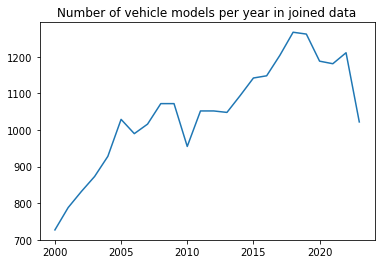

In [390]:
plt.plot(joined_data_00_23.groupby('Year').count()['Model'])
plt.title("Number of vehicle models per year in joined data")

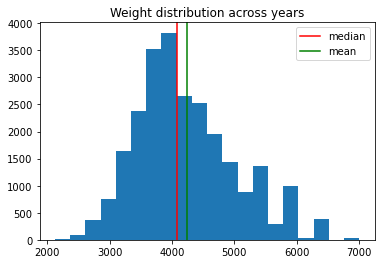

In [410]:
plt.hist(joined_data_00_23['AdjWeight'], bins = 20)
plt.axvline(np.median(joined_data_00_23['AdjWeight']), c = 'r', label = 'median')
plt.axvline(np.mean(joined_data_00_23['AdjWeight']), c = 'g', label = 'mean')
plt.title("Weight distribution across years")
plt.legend()

In [412]:
# test_df_vehicle = epa_df_cleaned[((epa_df_cleaned['Year'] == 2022) & (epa_df_cleaned['Make'] == 'Tesla'))]
# test_df_adj = combined_df1723[((combined_df1723['Year'] == 2022) & (combined_df1723['Make'] == 'Tesla'))]
# test_df_vehicle = epa_df_cleaned[(epa_df_cleaned['Year'] == 2022)]
# test_df_adj = combined_df1723[(combined_df1723['Year'] == 2022)]

In [411]:
# fuzzy_join(vehicle_df, combined_weights)

In [1351]:
### First join the 2000-2016 data, then join the 2017-2023 data
# joined_data_00_16 = vehicle_data_join_fuzzy(epa_df_cleaned, combined_csv0016)
# joined_data_17_23 = vehicle_data_join(epa_df_cleaned, combined_df1723)
# ## combine joined dataframes to create years 2000-2023
# joined_data_00_23 = pd.concat([joined_data_00_16, joined_data_17_23])
# joined_data_00_23['VehicleID'] = np.arange(0, len(joined_data_00_23)) ## assign new unique ids
# joined_data_00_23 = joined_data_00_23.reset_index().drop(['index'], axis = 1)

In [287]:
# full_test_join = vehicle_data_join_fuzzy(epa_df_cleaned[epa_df_cleaned['Year'] == 2000], 
#                                          combined_csv0016[combined_csv0016['Year'] == 2000])

In [391]:
# test_2008_adj = combined_df0023[combined_df0023['Year'] == 2022]
# test_2008_epa = epa_df_cleaned[epa_df_cleaned['Year'] == 2022]
# print(len(combined_csv0016[combined_csv0016['Year'] == 2008]))
# print(len(epa_df_cleaned[epa_df_cleaned['Year'] == 2008]))

In [392]:
# test_fuzzy_join = fuzzy_join(epa_df_cleaned, combined_csv0016)

In [402]:
epa_df_cleaned_drop = epa_df_cleaned[~epa_df_cleaned.duplicated(['Year', 'Make', 'Model', 'trany', 'displ', 'cylinders'])]

In [414]:
print("fraction of vehicles included in final join:", len(joined_data_00_23)/len(epa_df_cleaned_drop[epa_df_cleaned_drop['Year'] > 2000]))

fraction of vehicles included in final join: 0.981159307224216


### Teslas in dataset:

In [415]:
joined_data_00_23[joined_data_00_23['Make'] == 'Tesla'].head(50)

,level_0,Model,Make,Year,AdjWeight,match_index,baseModel,displ,cylinders,trany,...,highway08,city08,UCity,UHighway,atvType,rangeHwyA,RangeHwy,Range,MFRCode,VehicleID
12729,12729.0,Model S,Tesla,2012,4500.0,586.0,model s,NaN,NaN,Automatic (A1),...,90,88,110.4,113.2,EV,0.0,266.7800,265,TSL,12729
14661,14661.0,Model S (85 kW-hr battery pack),Tesla,2014,5250.0,1684.0,model s,NaN,NaN,Automatic (A1),...,90,88,110.4,113.2,EV,0.0,266.8000,265,TSL,14661
14662,14662.0,Model S AWD (85 kW-hr battery pack),Tesla,2014,5250.0,1684.0,model s,NaN,NaN,Automatic (A1),...,94,86,117.8,128.4,EV,0.0,253.2000,242,TSL,14662
15685,15685.0,Model S (85 kW-hr battery pack),Tesla,2015,5000.0,4115.0,model s,NaN,NaN,Automatic (A1),...,90,88,110.4,113.2,EV,0.0,266.8000,265,TSL,15685
15686,15686.0,Model S AWD - P85D,Tesla,2015,5000.0,4115.0,model s,NaN,NaN,Automatic (A1),...,98,89,121.1,132.3,EV,0.0,265.5000,253,TSL,15686
15687,15687.0,Model S AWD - 85D,Tesla,2015,5000.0,4115.0,model s,NaN,NaN,Automatic (A1),...,106,95,126.4,140.6,EV,0.0,285.3000,270,TSL,15687
15721,15721.0,Model S (60 kW-hr battery pack),Tesla,2015,5000.0,4114.0,model s,NaN,NaN,Automatic (A1),...,97,94,118.6,121.5,EV,0.0,210.7000,208,TSL,15721
15722,15722.0,Model S AWD - 70D,Tesla,2015,5000.0,4114.0,model s,NaN,NaN,Automatic (A1),...,102,101,133.7,135.0,EV,0.0,246.4000,240,TSL,15722
15723,15723.0,Model S AWD - 90D,Tesla,2015,5000.0,4114.0,model s,NaN,NaN,Automatic (A1),...,106,95,126.4,140.6,EV,0.0,285.3000,270,TSL,15723
15724,15724.0,Model S AWD - P90D,Tesla,2015,5000.0,4114.0,model s,NaN,NaN,Automatic (A1),...,98,89,121.1,132.3,EV,0.0,265.5000,253,TSL,15724


## Manual Validation (finds accuracy about 96-97%)

In [396]:
fuzzy_join_sample = joined_data_00_23.sample(200)

In [404]:
for model, weight in zip(fuzzy_join_sample['Model'], fuzzy_join_sample['AdjWeight']):
    print("Model: " + str(model), "|| AdjWeight: " + str(weight))

Model: Veracruz 4WD || AdjWeight: 4750.0
Model: Accord || AdjWeight: 3750.0
Model: Corolla || AdjWeight: 3156.25
Model: Flex AWD || AdjWeight: 5000.0
Model: Explorer AWD || AdjWeight: 5000.0
Model: Nitro 4WD || AdjWeight: 4500.0
Model: Z4 sDrive28i || AdjWeight: 3625.0
Model: Commander 2WD || AdjWeight: 4875.0
Model: F-Type S AWD Coupe || AdjWeight: 4375.0
Model: Blazer FWD || AdjWeight: 4250.0
Model: GX 470 || AdjWeight: 5250.0
Model: A4 Avant quattro || AdjWeight: 3781.25
Model: C70 Convertible || AdjWeight: 3958.3333333333335
Model: Ram 1500 Pickup 4WD || AdjWeight: 5750.0
Model: GL63 AMG || AdjWeight: 6000.0
Model: Cooper || AdjWeight: 3000.0
Model: Boxster || AdjWeight: 3312.5
Model: Solstice || AdjWeight: 3291.6666666666665
Model: Civic HF || AdjWeight: 3000.0
Model: Freelander || AdjWeight: 3875.0
Model: Flex AWD || AdjWeight: 5000.0
Model: Cruze || AdjWeight: 3511.904761904762
Model: Canyon 2WD || AdjWeight: 4375.0
Model: 911 GT3 || AdjWeight: 3625.0
Model: Dakota Pickup 2WD ||